In [1]:
import spot
spot.setup()
from spot.jupyter import display_inline

import fimdp
fimdp.setup()
from fimdp.labeled import LabeledConsMDP
from fimdp.energy_solvers import BasicES, GoalLeaningES, BUCHI

# Product of lCMDP with DBA and the link to LTL

The goal of this notebook is, given an LTL formula over the set $AP$ of atomic proposition and a consumption MDP with states labeled by subsets of $AP$, decide if there is a strategy for the MDP such that the LTL formula is satisfied with probability 1. We ilustrate the whole concept of a running example in which we want to enforce visiting 2 states (states `1` and `2`) infinitely often.

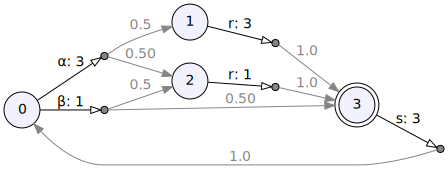

{1, 2}

In [2]:
from fimdp.examples.reachability_examples import product_example
mdp, T = product_example()
display(mdp, T)

In the following code, we verify that we can achieve the Büchi objective with targets set `{1,2}` with capacity `5` and that is not enough to visit the state `1`. What we actualy want is to visit **both** of these states infinitely often which we solve later.

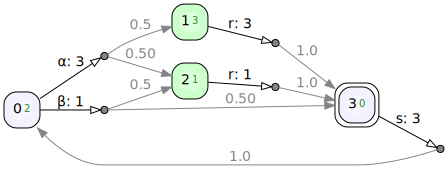

In [3]:
solver = BasicES(mdp, 5, T)
solver.get_min_levels(BUCHI)
solver

The corresponding strategy confirms that the state 1 won't be visited by the strategy as there is no occurence of the action `α`.

In [4]:
solver.get_selector(BUCHI)

[{2: 0——β[1]——>{2: Decimal('0.5'), 3: Decimal('0.50')}},
 {3: 1——r[3]——>{3: Decimal('1.0')}},
 {1: 2——r[1]——>{3: Decimal('1.0')}},
 {0: 3——s[3]——>{0: Decimal('1.0')}}]

## LTL and Büchi automata
Our goal of visiting both states `1` \& `2` infinitely often can be expressed by the LTL formula $\mathsf{G}\mathsf{F} s_1 \land \mathsf{G}\mathsf{F}s_2$ (or in the box-diamond notation: $\Box \diamond s_1 \land \Box \diamond s_2$) where the atomic proposition $s_1$ corresponds to visiting state `1` and the tomic proposition $s_2$ corresponds to visiting state`2`.

This formula can be expressed by a **deterministic** üchi automaton (DBA). We use Spot to make the translation for us. The option `BA` forces Spot to deliver a state-based Büchi automaton (default is transition-based generalized Büchi automaton), the option `deterministic` indicates that we prefer deterministic automata, and `complete` asks for an automaton with complete transition function. If you are not sure that your formula can be translated to a DBA, consult [hierarchy of LTL](https://spot.lrde.epita.fr/hierarchy.html). It is also a good practice to make yourself sure by running 
```python
aut.is_deterministic()
```

In [5]:
f = spot.formula("GF s1 & GF s2")
aut = spot.translate(f, "Buchi", "SBAcc", "deterministic", "complete")

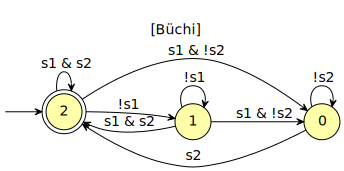

True

In [6]:
display(aut, aut.is_deterministic())

The produced automaton can be used in parallel with our input MDP; this is achieved by a _product_ (alternatively _parallel synchonous composition_) of this automaton an the input MDP. But we need to label states of the MDP with the atomic propositions `s₁` and `s₂`.

## Labeled CMDP
We create a copy of our CMDP and label the states `1` and `2` with the corresponding atomic propositions using the function
```python
LabeledConsMDP.state_labels(labels)
```
where `labels` is a list (of length equal to number of states) of sets of ints; the ints are indices to the list `AP` given in the constructor of `LabeledConsMDP`.

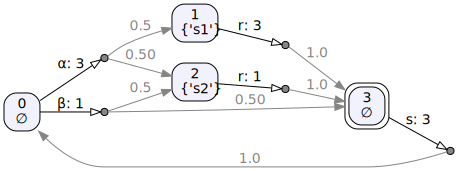

In [7]:
lmdp = LabeledConsMDP(AP=["s1","s2"], mdp=mdp)
lmdp.state_labels = [set(), {0}, {1}, set()]
display(lmdp)

## Product of labeled CMDP and DBA

In the following, we explain and show the (simplified) implementation of `LabeledConsMDP.product(self, dba)`.

The states of the product are tuples `(ms,as)` where `ms` stands for a state of the MDP and `as` stands for a states of the automaton. Let's call the set of states of the MDP $S$ and the set of states of the DBA $Q$; further, the labeling function of the labeled MDP is $\lambda \colon S \to 2^{AP}$ and the transition function of the DBA as $\delta \colon Q \times 2^{AP} \to Q$. For each action `α` and each successor `ms'` for this action from state `ms`, the action `α` of `(ms,as)` has an `α` successor (with the same probability) `(ms', as')` where `as'` is equal to $\delta(as, \lambda(ms'))$.

All tuples that contain a reload state of the mdp, are again reloading. All tuples with an accepting state of the automaton will become targets. The following function `product(lmdp, aut)` returns a CMDP that is the product of `lmdp` and `aut` and a list of target states.

We can now see the result of the product on the labeled MDP and the automaton for $\mathsf{G}\mathsf{F}s_1 \land \mathsf{G}\mathsf{F} s_2$. We can also see that capacity 5 is no longer sufficient for the Büchi objective (the green ∞ indicate that no initial load is sufficient from given state to satisfy the Büchi objectives with targets `T`).

In [8]:
p, T = lmdp.product_with_dba(aut)
psolver = BasicES(p, 5, T)
res = psolver.get_min_levels(BUCHI, True)
display_inline(psolver)

In [9]:
from math import inf
assert res == [inf, inf, inf, inf, inf, inf, inf]

In fact, we need at least 9 units of energy to pass the path through mdp-state `1`.

In [10]:
psolver.cap = 9
res = psolver.get_min_levels(BUCHI, recompute=True)
display_inline(psolver)

## Products, action selectors, and strategies
See [Strategies.ipynb](Strategies.ipynb) to learn more about strategies and selectors in general.

By default, solvers return `CounterSelectors` which work on the product mdp and map each state to a selection rule.

In [11]:
selector_on_product = psolver.get_selector(BUCHI)
selector_on_product

[{6: 0——α[3]——>{1: Decimal('0.5'), 2: Decimal('0.50')},
  2: 0——β[1]——>{2: Decimal('0.5'), 3: Decimal('0.50')}},
 {3: 1——r[3]——>{4: Decimal('1.0')}},
 {1: 2——r[1]——>{3: Decimal('1.0')}},
 {0: 3——s[3]——>{0: Decimal('1.0')}},
 {0: 4——s[3]——>{5: Decimal('1.0')}},
 {2: 5——β[1]——>{6: Decimal('0.5'), 4: Decimal('0.50')}},
 {1: 6——r[1]——>{3: Decimal('1.0')}}]

We can ask the solver to use `ProductSelector` instead by the following command.
```python
solver.SelectorClass = ProductSelector
```
ProductSelector work on pairs of the original labelled MDP and the automaton and the actions it returns are actually actions of the original MDP and not the product ones.

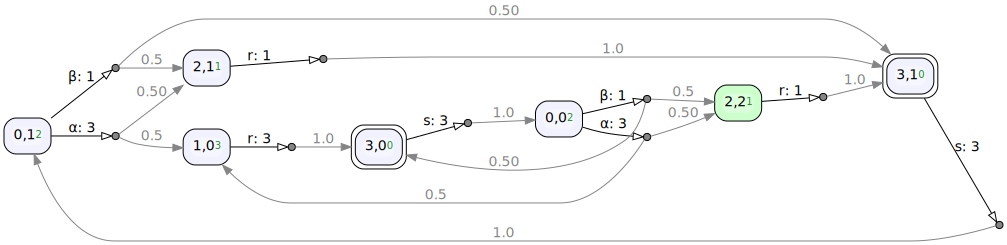

In [12]:
psolver

In [13]:
from fimdp.core import ProductSelector

psolver = GoalLeaningES(p, 9, T)
psolver.SelectorClass = ProductSelector
selector_on_orig = psolver.get_selector(BUCHI, recompute=True)
selector_on_orig

===ProductSelector===
 0×0: {2: 0——β[1]——>{2: Decimal('0.5'), 3: Decimal('0.50')}}
 0×1: {6: 0——α[3]——>{1: Decimal('0.5'), 2: Decimal('0.50')}, 2: 0——β[1]——>{2: Decimal('0.5'), 3: Decimal('0.50')}}
 1×0: {3: 1——r[3]——>{3: Decimal('1.0')}}
 2×1: {1: 2——r[1]——>{3: Decimal('1.0')}}
 2×2: {1: 2——r[1]——>{3: Decimal('1.0')}}
 3×0: {0: 3——s[3]——>{0: Decimal('1.0')}}
 3×1: {0: 3——s[3]——>{0: Decimal('1.0')}}

Alternatively, the `ProductSelector` that works on the original labeled MDP is accessible using the function `selector_for_dba` of `LabeledConsMDP` object.

In [14]:
assert selector_on_orig == lmdp.selector_for_dba(aut)

In [15]:
display_inline(mdp, p)

We demonstrate the difference on the two occurences of the original mdp state 0 in the product. In both product states `0,1` and `0,0` that correspond to the state `0` in the original mdp, the labels of the actions picked by the two selectors agree. However, as you can notice in the second cell, the state numbers of the actions are different as they correspond to states in the original MDP in case of `selector_on_orig` and to states in the product MDP in case of `selector_on_product`.

In [16]:
orig_mdp_s = 0
aut_s = 1
energy = 7
product_mdp_s = p.components_to_states_d[(orig_mdp_s, aut_s)]
print(selector_on_orig.select_action(orig_mdp_s, aut_s, energy))
print(selector_on_product.select_action(product_mdp_s, energy))

0——α[3]——>{1: Decimal('0.5'), 2: Decimal('0.50')}
0——α[3]——>{1: Decimal('0.5'), 2: Decimal('0.50')}


In [17]:
aut_s = 0
product_mdp_s = p.components_to_states_d[(orig_mdp_s, aut_s)]
print(selector_on_orig.select_action(orig_mdp_s, aut_s, energy))
print(selector_on_product.select_action(product_mdp_s, energy))

0——β[1]——>{2: Decimal('0.5'), 3: Decimal('0.50')}
5——β[1]——>{6: Decimal('0.5'), 4: Decimal('0.50')}


The actions look quite the same, but are actually different: this is because they belong to different MDPs.

In [18]:
aut_s = 1
product_mdp_s = p.components_to_states_d[(orig_mdp_s, aut_s)]
a1 = selector_on_orig.select_action(orig_mdp_s, aut_s, energy)
a2 = selector_on_product.select_action(product_mdp_s, energy)
print(a1)
print(a2)
a1 == a2

0——α[3]——>{1: Decimal('0.5'), 2: Decimal('0.50')}
0——α[3]——>{1: Decimal('0.5'), 2: Decimal('0.50')}


False

### Use of selectors in strategies

In [19]:
f = spot.formula("GF s1 & GF s2")
aut = spot.translate(f, "Buchi", "SBAcc", "deterministic", "complete")
mdp, T = product_example()
lmdp = LabeledConsMDP(AP=["s1","s2"], mdp=mdp)
lmdp.state_labels = [set(), {0}, {1}, set()]

capacity = 10
init_energy = 5

We create 2 strategies:
 1. A `CounterStrategy` that works on product CMDP
 2. A `DBACounterStrategy` that works on labeled CMDP

In [20]:
# Get CounterSelector
product, targets = lmdp.product_with_dba(aut)
psolver = GoalLeaningES(product, capacity, targets)
psolver.get_min_levels(BUCHI, recompute=True)
counter_sel = psolver.get_selector(BUCHI)

In [21]:
# Get ProductSelector
dba_sel = lmdp.selector_for_dba(aut, cap=capacity)

In [22]:
from fimdp.core import CounterStrategy
from fimdp.labeled import DBACounterStategy
cs = CounterStrategy(product, counter_sel, capacity, init_energy)
dbas = DBACounterStategy(lmdp, aut, dba_sel, capacity, init_energy)

We now start a play from the initial states (0 in both cases) and check whether the strategies give equivalent choices. We will use the states of the product to give the outcomes, but traslate them for the `DBACounterStrategy` to the states of the original MDP.

In [23]:
display_inline(mdp, p)

In [24]:
for outcome in [0, 2, 3, 0, 2, 3, 0, 1, 4, 5, 4, 5, 6, 3, 0]:
    pr_action = cs.next_action(outcome)
    orig_outcome = product.components[outcome][0]
    orig_action = dbas.next_action(orig_outcome)
    print(f" product: {outcome} — {pr_action.label},"
          f" original: {orig_outcome} — {orig_action.label}")
    assert product.orig_action(pr_action) == orig_action

 product: 0 — β, original: 0 — β
 product: 2 — r, original: 2 — r
 product: 3 — s, original: 3 — s
 product: 0 — α, original: 0 — α
 product: 2 — r, original: 2 — r
 product: 3 — s, original: 3 — s
 product: 0 — α, original: 0 — α
 product: 1 — r, original: 1 — r
 product: 4 — s, original: 3 — s
 product: 5 — β, original: 0 — β
 product: 4 — s, original: 3 — s
 product: 5 — β, original: 0 — β
 product: 6 — r, original: 2 — r
 product: 3 — s, original: 3 — s
 product: 0 — α, original: 0 — α


In [25]:
spot.is_recurrence(f)

True

## The link back to LTL

Finally, the class `LabeledConsMDP` implements `selector_for_ltl` (with similar interface as `selector_for_dba`) which returns the `ProductSelector` for the automaton equivalent to the given formula.

In [26]:
ltl_sel = lmdp.selector_for_ltl("GF s1 & GF s2", cap=capacity)
ltl_sel == dba_sel

True